In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/tf/notebooks/src


## Intialization

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Packages

In [4]:
try:
    import pandas
except:
    !pip install pandas seaborn iterative-stratification nlpaug==0.0.20 tqdm click tensorflow_probability==0.11.1 tf2_resnets tensorflow_addons==0.11.1 image-classifiers==0.2.2

### Imports

In [5]:
import os
import glob
import random
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import *

from train import get_model
from split_data import get_split
from metrics import LwlrapAccumulator
from dataloaders.val import MelSampler
from dataloaders.utils import csv_to_dict

In [6]:
from params import *
from utils.metric import lwlrap

## Main

In [7]:
def run_multi_scale_eval(model_name, checkpoints_path, fold, scales):
    """
    This function will compute each species's lrap at different scale.
    The idea is, for each species in test-set, we will use its predicted
    value at the scale that maximize its lrap in eval set. in the case
    that the maximum lrap value is achieved at many different scales, let take a
    maximum scale because the smaller scale, the more false positive samples.
    """
    train_data = pd.read_csv("../data/new_train_tp.csv")
    _, val_index = get_split(fold=fold)
    valid_dataset_csv = train_data.iloc[val_index]

    valid_data_loader = MelSampler(
        csv_to_dict(valid_dataset_csv),
        cache=True,
        batch_size=64,
        n_classes=24,
        is_train=False,
        use_cutmix=False,
        shuffle_aug=False,
        max_length=384,
    )
    all_checkpoints = sorted(
        glob.glob(os.path.join(checkpoints_path, f"fold{fold}", "model-*.h5"))
    )

    model = get_model(
        model_name=model_name,
        saved_path=checkpoints_path,
        pretrained_with_contrastive=False,
        pretrained_path=all_checkpoints[-1],
    )
    
    lwlrap_at_scale = np.zeros((len(scales), NUM_CLASSES))
    preds = []

    for s, max_length in enumerate(scales):
        valid_data_loader.max_length = max_length
        clip_preds = model.predict(valid_data_loader, verbose=0)  # [B, 24]
        clip_preds = tf.nn.sigmoid(clip_preds).numpy()
        
        preds.append(clip_preds)

        # compute gts
        gts = []
        for i in range(len(valid_dataset_csv)):
            gts.append(valid_dataset_csv.iloc[i]["species_id"])
        gts = tf.keras.utils.to_categorical(gts, 24)

        class_lwlrap, _ , score = lwlrap(gts, clip_preds)
        
        lwlrap_at_scale[s] = class_lwlrap
        print(f"Scale {scales[s]}:\t{score:.3f}")                     

    np.save(
        os.path.join(checkpoints_path, f"lwlrap_at_scale_{fold}.npy"),
        lwlrap_at_scale,
    )
    
    return lwlrap_at_scale, np.array(preds), gts

In [8]:
CP_FOLDER = LOG_PATH + "2021-02-04/9/"
CP_FOLDER = LOG_PATH + "2021-02-04/12/"
# CP_FOLDER = "../data/densenet121_pretrained/"  # 0.897

In [9]:
CP_FOLDERS = [
    LOG_PATH + "2021-02-04/9/"
]

MODELS = [
    'densenet121',
]

In [10]:
MODELS = [
   'densenet121',
#     'resnet18',
#     'resnet34',
#     'resnext50',
#     'efficientnetb2',
#     "xception",
#     'resnest50',
#     'efficientnetb3',
]

In [11]:
CP_FOLDERS = [
#     "../logs/2021-02-14/8/",
#     "../logs/2021-02-14/9/",
#     "../logs/2021-02-14/10/",
#     "../logs/2021-02-15/0/",
#     "../logs/2021-02-15/1/",
#     "../logs/2021-02-15/2/",
    "../logs/2021-02-15/3/",
    
]

In [13]:
for model_name, CP_FOLDER in zip(MODELS, CP_FOLDERS):
    
    print(f'\n########################\n -> Log folder : {CP_FOLDER}\n########################\n')
    lwlraps = []
    preds = []
    best_preds = []
    ys = []

    for fold_idx in range(5):
        tf.keras.backend.clear_session()
        print(f"\n-------------   Fold {fold_idx + 1} / {5}  -------------\n")

        lwlrap_at_scale, pred, y = run_multi_scale_eval(model_name, CP_FOLDER, fold_idx, SCALES)

        best_pred = []
        for c in range(NUM_CLASSES):  # extended argmax
            best_score = lwlrap_at_scale[:, c].max()
            best_indexes = [i for i, j in enumerate(lwlrap_at_scale[:, c]) if j == best_score]
            class_preds = [pred[idx, :, c] for idx in best_indexes]
    #         best_pred.append(np.mean(class_preds, 0))
            best_pred.append(class_preds[-1])
        best_pred = np.array(best_pred).T

    #     best_pred = np.array([pred[lwlrap_at_scale[:, i].argmax(), :, i] for i in range(NUM_CLASSES)]).T  # argmax

        score = lwlrap(y, best_pred)[-1]

        print(f'\nMulti-scale : {score:.3f}')

        lwlraps.append(lwlrap_at_scale)
        best_preds.append(best_pred)
        preds.append(pred)
        ys.append(y)
        
    score = lwlrap(np.concatenate(ys), np.concatenate(best_preds))[-1]

    print(f'\n########################\nLocal CV score {score:.3f}\n########################\n')


########################
 -> Log folder : ../logs/2021-02-16/1/
########################


-------------   Fold 1 / 5  -------------

 -> Loading weights from ../logs/2021-02-16/1/fold0/model-0.820-0.130.h5

Scale 32:	0.549
Scale 64:	0.716
Scale 128:	0.814
Scale 192:	0.852
Scale 256:	0.856
Scale 320:	0.850
Scale 384:	0.840
Scale 448:	0.820
Scale 512:	0.811

Multi-scale : 0.832

-------------   Fold 2 / 5  -------------

 -> Loading weights from ../logs/2021-02-16/1/fold1/model-0.860-0.116.h5

Scale 32:	0.605
Scale 64:	0.795
Scale 128:	0.869
Scale 192:	0.886
Scale 256:	0.892
Scale 320:	0.882
Scale 384:	0.862
Scale 448:	0.855
Scale 512:	0.859

Multi-scale : 0.894

-------------   Fold 3 / 5  -------------

 -> Loading weights from ../logs/2021-02-16/1/fold2/model-0.796-0.125.h5

Scale 32:	0.549
Scale 64:	0.723
Scale 128:	0.814
Scale 192:	0.830
Scale 256:	0.837
Scale 320:	0.827
Scale 384:	0.805
Scale 448:	0.798
Scale 512:	0.796

Multi-scale : 0.839

-------------   Fold 4 / 5  ----------

In [10]:
score = lwlrap(np.concatenate(ys), np.concatenate(best_preds))[-1]

print(f'Local CV score {score:.3f}')

Local CV score 0.904


## Confidences

In [11]:
df = pd.read_csv('../data/new_train_tp.csv')

pred_oof = np.zeros((len(df), NUM_CLASSES))

for i in range(5):
    _, val_index = get_split(fold=i)
    
    pred_val = preds[i]
    lwlrap_at_scale = lwlraps[i]
    
    best_pred = []
    for c in range(NUM_CLASSES):  # extended argmax
#         best_score = lwlrap_at_scale[:, c].max()
#         best_indexes = [i for i, j in enumerate(lwlrap_at_scale[:, c]) if j == best_score]

        best_indexes = [-1] # only 512
        class_preds = [pred_val[idx, :, c] for idx in best_indexes]
        best_pred.append(class_preds[-1])
    best_pred = np.array(best_pred).T
    pred_oof[val_index] = best_pred

In [12]:
confidences = []
has_others = []
for i in range(len(df)):
    pred = pred_oof[i].copy()
    
#     print(pred, df['species_id'][i], pred[df['species_id'][i]], pred.max())
    confidences.append(pred[df['species_id'][i]])
    
    pred[df['species_id'][i]] = 0
    has_others.append(int(pred.max() > 0.5))
    
#     break

In [13]:
df['confidence'] = confidences
df['has_other'] = has_others

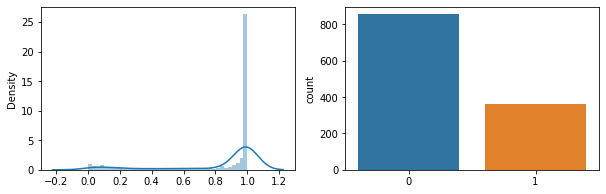

In [14]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.distplot(confidences)
plt.subplot(1, 2, 2)
sns.countplot(has_others)
plt.show()

In [15]:
df.to_csv(OUT_DIR + 'df_tp_conf.csv', index=False)